In [6]:
import sys
import os
import time
import warnings
sys.path.append(os.path.abspath(os.path.join('../../')))
warnings.filterwarnings("ignore")

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from evaluation import full_evaluate

In [8]:
# Reading the dataset
df = pd.read_csv("../../datasets/final_features_dataset.csv")

# Separating features and target variable
X = df.drop(columns=['is_fraud', 'Unnamed: 0'])
y = df['is_fraud']

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Convert data to arrays if they are not already
X_train = X_train.values if isinstance(X, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y, pd.Series) else y_train

In [9]:
# Defining the hyperparameter search space
hyperparameter_space = {
    "n_estimators": [50, 500],
    "max_depth": [1, 30],
    "learning_rate": [0.01, 0.3],
    "subsample": [0.5, 1.0],
    "colsample_bytree": [0.3, 1.0],
    "min_child_weight": [1, 10],
    "gamma": [0, 0.5],
    "reg_alpha": [0, 1],
    "reg_lambda": [0, 1],
}

# Define fitness function to evaluate model performance
def fitness(hyperparameters, get_model = False):
    """
    Function to evaluate the fitness of decision tree model with given hyperparameters.

    Args:
    hyperparameters (list): List of hyperparameter values.
    get_model (bool): If True, returns the model only, otherwise returns the fitness score.

    Returns:
    float or DecisionTreeClassifier: Fitness score if get_model=False, else the model itself.
    """
    # Check if hyperparameters are within defined ranges
    for i, value in enumerate(hyperparameters):
        param_name = list(hyperparameter_space.keys())[i]
        range_min = hyperparameter_space[param_name][0]
        range_max = hyperparameter_space[param_name][1]
        if not (range_min <= value <= range_max):
            return float('-inf') # Penalize if hyperparameters are out of range

    # Create XGBoost model with specified hyperparameters
    model = XGBClassifier(
        n_estimators=int(hyperparameters[0]),
        max_depth=int(hyperparameters[1]),
        learning_rate=float(hyperparameters[2]),
        subsample=float(hyperparameters[3]),
        colsample_bytree=float(hyperparameters[4]),
        min_child_weight=float(hyperparameters[5]),
        gamma=float(hyperparameters[6]),
        reg_alpha=float(hyperparameters[7]),
        reg_lambda=float(hyperparameters[8]),
        random_state=0,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # If only model is requested, return the model
    if get_model:
        print('Best parameters', {
            "n_estimators": int(hyperparameters[0]),
            "max_depth": int(hyperparameters[1]),
            "learning_rate": float(hyperparameters[2]),
            "subsample": float(hyperparameters[3]),
            "colsample_bytree": float(hyperparameters[4]),
            "min_child_weight": float(hyperparameters[5]),
            "gamma": float(hyperparameters[6]),
            "reg_alpha": float(hyperparameters[7]),
            "reg_lambda": float(hyperparameters[8]),
            "use_label_encoder": False,
            "eval_metric": 'logloss'
        })
        return model
    else:
        # Initialize cross-validation
        cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
        cv_results = []
        
        # Perform cross-validation
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            # smote oversampling
            sm = SMOTE()
            X_train_fold, y_train_fold = sm.fit_resample(X_train_fold, y_train_fold)
            
            # Fit the model
            model = model.fit(X_train_fold, y_train_fold)
            
            # Make predictions
            y_train_pred = model.predict(X_train_fold)
            y_test_pred = model.predict(X_test_fold)
            
            # Calculate evaluation metrics
            f1_train = f1_score(y_train_fold, y_train_pred)
            f1_test = f1_score(y_test_fold, y_test_pred)

            # Store results
            cv_results.append({'f1_train': f1_train, 'f1_test': f1_test})
        
        # Extracting F1 scores for training, testing, and validation sets from cross-validation results
        f1_train = np.array([fold["f1_train"] for fold in cv_results])
        f1_test = np.array([fold["f1_test"] for fold in cv_results])
        
        # Initialize the score variable to negative infinity
        score = float("-inf")
        # Check if the standard deviation of the mean F1 scores across training, testing, and validation sets is less than 0.01
        if np.array([f1_train.mean(), f1_test.mean()]).std()<0.001:
            # If the condition is met, set the score to the mean F1 score of the validation set
            score = f1_test.mean()
        return score

New best 0.9235172327830002
New best 0.9246212809596479
New best 0.9256808834517649
New best 0.9267849316284127


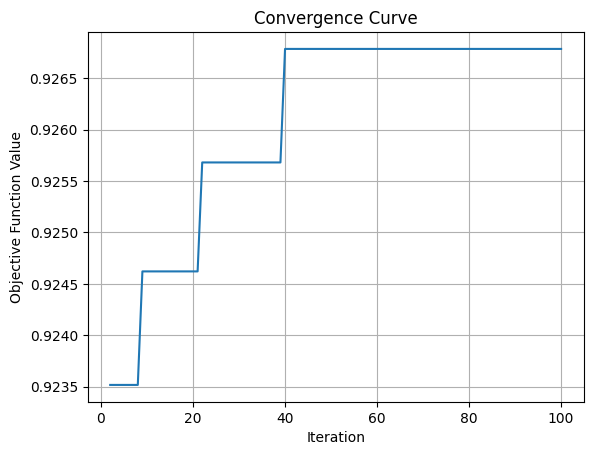

Best parameters {'n_estimators': 66, 'max_depth': 1, 'learning_rate': 0.026620474144557097, 'subsample': 0.5, 'colsample_bytree': 0.3197111628043255, 'min_child_weight': 1.1073276358362916, 'gamma': 0.0, 'reg_alpha': 0.0005317644148030426, 'reg_lambda': 0.0, 'use_label_encoder': False, 'eval_metric': 'logloss'}
Training set Counter({0: 8780, 1: 8780}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8780, 1: 8780}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8780, 1: 8780}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8781, 1: 8781}) Test set Counter({0: 2926, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Fold 1: (Train F1: 0.92, Test F1: 0.92, Validation F1: 0.90, Precision: 1.00, Recall: 0.83, Accuracy: 0.99).
Fold 2: (Train F1: 0.92, Test F1: 0.94, Validation F1: 0.91, Precision: 1.00, Recall: 0.84, Accuracy: 

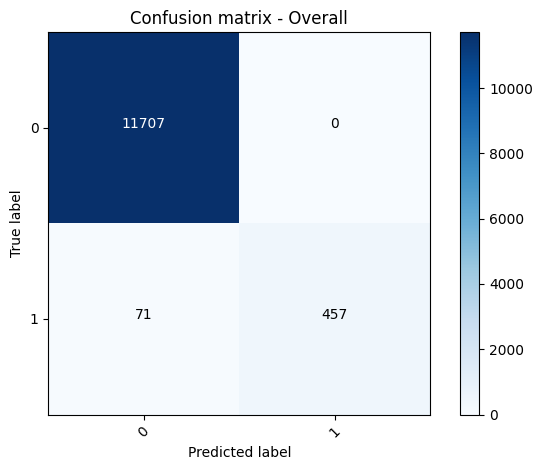

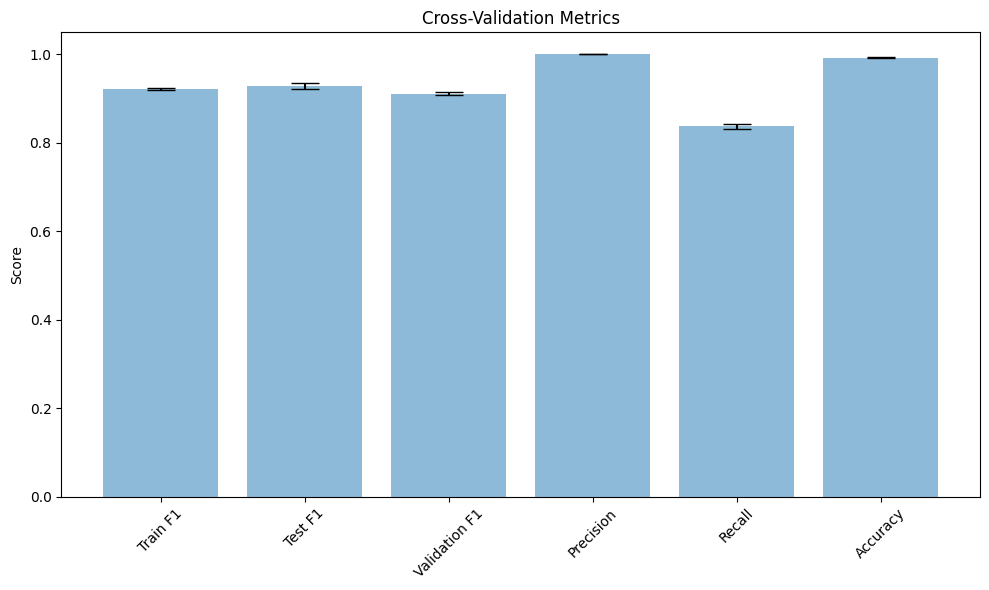

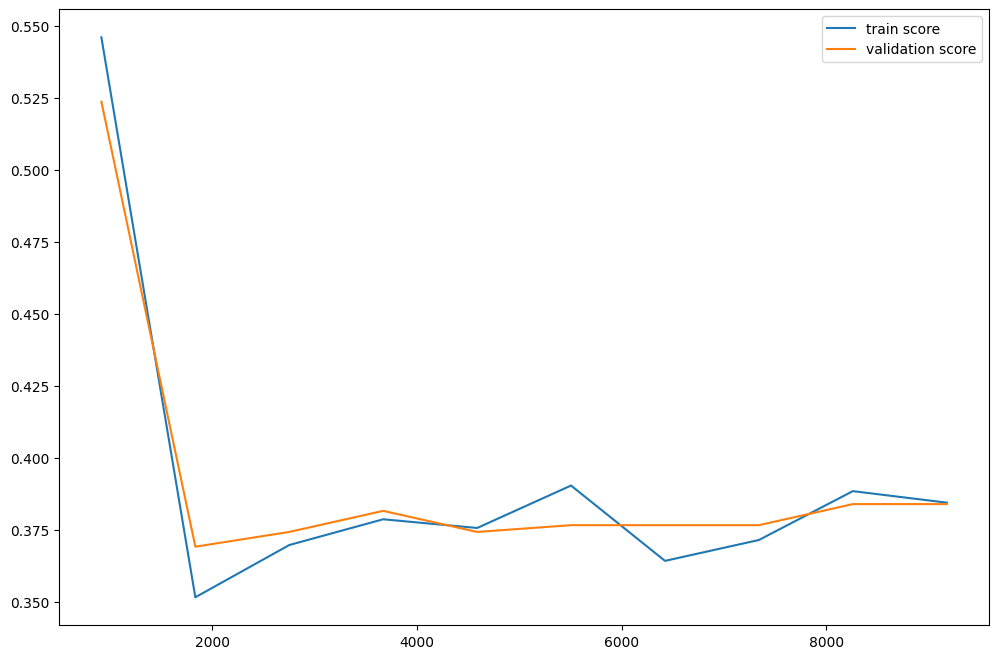

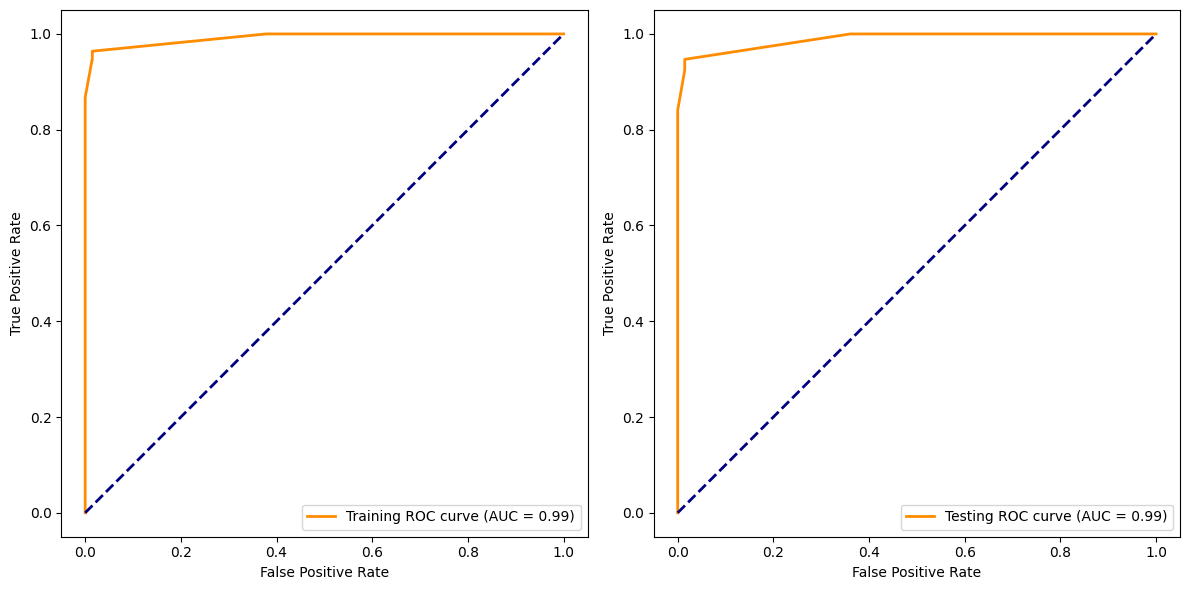

343.9736511707306 seconds


In [10]:
# Measure the start time for the optimization process
starting = time.time()

# Perform hyperparameter optimization using the Harris Hawks Optimization algorithm
# The `full_evaluate` function evaluates the fitness of each individual (hawk) in the population
# by calling the `fitness` function defined earlier
# `fitness` is the function that computes the fitness score for each set of hyperparameters
# `X` is the feature dataset
# `y` is the target variable
# `hyperparameter_space` defines the search space for hyperparameters
# `sampling` is an optional parameter to specify the sampling method
# `max_iter` specifies the maximum number of iterations for the HHO algorithm
# `pop_size` specifies the population size for each iteration
full_evaluate.full_evaluate(fitness, X, y, hyperparameter_space, sampling='smote', max_iter=100, pop_size=5)

# Measure the time taken for optimization by calculating the difference between the start time and the current time
exec_time = time.time() - starting

# Print the execution time in seconds
print(exec_time, "seconds")